# Transformer From Scratch

## References

* https://arxiv.org/abs/1706.03762 (Attention is all you need)
* https://www.youtube.com/watch?v=eMlx5fFNoYc (3Blue1Brown)
* https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html (Sebastian Raschka)
* https://www.youtube.com/watch?v=kCc8FmEb1nY (Andrej Karapathy)
* https://arxiv.org/pdf/2005.14165 (Language Models are Few-Shot Learners)
* https://arxiv.org/abs/1512.03385 (Deep Residual Learning for Image Recognition)
* https://arxiv.org/pdf/1607.06450 (Layer Norm)


## Architecture

![transformers](./images/Arch_Transformers.png)

In [127]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

torch.manual_seed(1)


## Embedding

* Creating dummy encodings here to replicate the effect of any embedding model.
* We can pick any pretrained embedding model (word2vec, bert etc.) to get word vectors.
* Idea is to get vector representation of each word with comparable information in a mathematical plane.



### Tokenization

Sentence - `I am new to NLP with Deep Learning.`

Convinient Lie - `I|am|new|to|NLP|with|Deep|Learning|.` (We'll be using this for now. Easy to interpret)

Actual Truth - `I |am |new to| NLP |with |Deep |Learn|ing.` (this is done using BytePairEncoding)

### Byte Pair Encoding

* https://huggingface.co/learn/nlp-course/en/chapter6/5

1. separate each character, add everything in vocab
2. create character pairs and find frequency of each pair
3. add most frequent pair to the vocab
4. repeat step 2 and 3 till the point there's no more frequent pair left or desired vocab size is reached.

In [128]:
from collections import Counter

with open("./corpus.txt", "+r") as file:
    corpus = file.read()
# paragraph = """I am new to NLP with deep learning. I like deep learning and I like NLP. I am trying to combine it. Deep learning is a type of machine learning that uses artificial neural networks to teach computers to process data in a way that mimics the human brain. Deep learning can be used to solve a variety of problems, including: 
# image recognition, natural language processing, speech recognition, object detection, drug discovery, and genomics. deep learning: Overview of Neurons and Activation Functions. Deep learning models learn from large amounts of data by performing a task repeatedly and tweaking it slightly to improve the outcome. This process is similar to how humans learn from experience."""

chars = [i for i in corpus]

vocab = [i for i in "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890!@#$%^&*()_-+=:;<>.,?/\\|}{[] "]
vocab.extend(list(set(corpus.split(" "))))
len(vocab)

434

Running the algorithm till the point we get no additional pairs to add to a vocab list.

In [129]:
while True:
    char_counts = Counter(chars)
    char_len = len(chars)
    byte_pair = []
    i = 0
    while i < char_len:
        token = chars[i]
        j = i + 1
        while j < char_len:
            tmp_token = token + chars[j]
            if tmp_token in vocab:
                token = tmp_token
                j += 1
            else:
                byte_pair.append(tmp_token)
                break
        i = j
    byte_pair.append(token)

    any_new_result = False
    byte_pair_counts = Counter(byte_pair)
    for key, val in byte_pair_counts.items():
        if val > 2:
            if key not in vocab:
                vocab.append(key)  
                any_new_result = True
    if not any_new_result:
        break

any_new_result, len(vocab)

(False, 1298)

In [130]:
tokenizer = {val:idx for idx, val in enumerate(vocab)}

In [131]:
def tokenize(sentence, tokenizer):
    sentence_len = len(sentence)
    tokens = []
    i = 0
    while i < sentence_len:
        token = sentence[i]
        j = i + 1
        while j < sentence_len:
            tmp_token = token + sentence[j]
            if tmp_token in vocab:
                token = tmp_token
                j += 1
            else:
                tokens.append({ tokenizer[token] : token } )
                break
        i = j
    tokens.append({ tokenizer[token] : token } )
        
    return tokens

tokenize("Do I like deep learning?", tokenizer)

[{29: 'D'},
 {695: 'o '},
 {34: 'I'},
 {946: ' lik'},
 {479: 'e '},
 {1240: 'deep learning'},
 {82: '?'}]

In [132]:
tokenize("We have to learn deep learning", tokenizer)

[{48: 'W'},
 {479: 'e '},
 {461: 'ha'},
 {869: 've '},
 {527: 'to '},
 {1007: 'learn '},
 {1240: 'deep learning'}]

Here my training data (corpus) is small hence it is not able to get `Do` as a single token and similar case in other words as well. But as we improve the corpus most common words and pairings will create a really good vocabulary.

Good thing about BPE is that it accounts for special characters as well, that most commonly appear in a sentence sequentially.

### Legacy Tokenization

In [133]:
paragraph = """I am new to NLP with deep learning. I like Deep Learning and I like NLP. I am trying to combine it."""


bow = paragraph.lower().replace(".", "").split(" ")

vocab = set(bow)

In [134]:
tokenizer = {val: idx for idx, val in enumerate(vocab)}

In [135]:
def sentence_separator(sentence):
    return sentence.lower().replace(".", "").split(" ")


def get_tokens(sentence):
    sentence_sep = sentence_separator(sentence)
    tokens = torch.Tensor([tokenizer[i] for i in sentence_sep]).type(torch.int32)
    return tokens


def get_embedding(tokens, dim=30):
    embed = torch.nn.Embedding(len(vocab), dim)

    # detach will make it non learnable parameter and in case of transformers 
    # it is not needed to have learnable embeddings
    # if we are using pretrained models
    embedded_sentence = embed(tokens).detach()
    return embedded_sentence

In [136]:
sentence = "I like NLP"
tokens = get_tokens(sentence)
tokens

tensor([ 9,  1, 11], dtype=torch.int32)

In [137]:
get_embedding(tokens, dim=10)

tensor([[-1.0412,  0.7323, -1.0483, -0.4709,  0.2911,  1.9907,  0.6614,  1.1899,
          0.8165, -0.9135],
        [-0.7773, -0.2515, -0.2223,  1.6871,  0.2284,  0.4676, -0.6970, -1.1608,
          0.6995,  0.1991],
        [-1.4782, -1.1334,  0.8738, -0.5603,  0.3539,  1.1996, -0.3030, -1.7618,
          0.6348, -0.8044]])

## Positional Encoding

![positional encoding](images/Arch_PositionalEncoding.png)

* As attention is mechanism is desined to work in parallel (as opposed to older Seq2Seq Model to overcome the performance issue) to provide the sense of sequence in input tokens is necessary.
* Positional Encoding provides each token a positional aware representation in a sequence

> In a sentence **This is going to happen anyways** . the relationship has to be represented that **going** is two steps after **This** and **to** is one steps after **going**, this positional awareness/ markers of the position in the sentence has to be infused somehow in the input embeddings of set of tokens in sequence.

* Each position has a UNIQUE encoding
* Compatible with Attention Mechanism
* Due to sine and cosine - it is scale invariant

\begin{align*}
PE(pos, 2i) &= \sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}}) \\\\
PE(pos, 2i + 1) &= \cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}}) \\\\
\text{where, }
pos &= \text{Position of token in sequence} \\
i &= \text{index of dimension} \\
d_{model} &= \text{dimension of model\ embdeding size of the model} \\
\end{align*}

* Single value of $i \in [0, d_{model})$ map both sine and cosine function
* values will reside in -1 and 1
* 10000 is a scaling value
* Why sine & cosine ? 
    * Phase difference encoding uniqueness
    * Linearly independent
    * due to sine and cosine properties, calculatable that token 5 is closer to token 6 than token 10 without maintaining a sequence,

In [138]:
def positional_encoding(n_tokens, d_model, scale=10_000):
    """
    * Rows - Positions (sentence length, number of tokens in input sentence)
    * Columns - Dimensions (Dimensions of embedding or models)
    """
    p = torch.zeros((n_tokens, d_model))
    positions = torch.arange(n_tokens)

    # for loop approach - just need to run it for half of the dimensions as 
    for i in range(int(d_model / 2)):
        denominator = 1 / math.pow(scale, (2 * i) / d_model)

        p[positions, 2 * i] = torch.sin(positions * denominator)
        p[positions, (2 * i) + 1] = torch.cos(positions * denominator)
    return p

positional_encoding(5, 5)

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [ 0.8415,  0.5403,  0.0251,  0.9997,  0.0000],
        [ 0.9093, -0.4161,  0.0502,  0.9987,  0.0000],
        [ 0.1411, -0.9900,  0.0753,  0.9972,  0.0000],
        [-0.7568, -0.6536,  0.1003,  0.9950,  0.0000]])

In [139]:
def positional_encoding_opt(n_tokens, d_model, scale=10_000):
    """
    * Rows - Positions (sentence length, number of tokens in input sentence)
    * Columns - Dimensions (Dimensions of embedding or models)
    """
    p = torch.zeros((n_tokens, d_model))
    positions = torch.arange(n_tokens).unsqueeze(1)
    denominator = 1 / torch.pow(scale, torch.arange(0, d_model, 2).unsqueeze(0) / d_model)

    if d_model % 2 == 0:
        end_idx = denominator.shape[1]
    else:
        end_idx = denominator.shape[1] - 1
    
    # for even indexes
    p[:, 0::2] = torch.sin(positions * denominator)

    # for odd indexes
    p[:, 1::2] = torch.cos(positions * denominator[:, :end_idx])
    return p


positional_encoding_opt(5, 5)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  2.5116e-02,  9.9968e-01,  6.3096e-04],
        [ 9.0930e-01, -4.1615e-01,  5.0217e-02,  9.9874e-01,  1.2619e-03],
        [ 1.4112e-01, -9.8999e-01,  7.5285e-02,  9.9716e-01,  1.8929e-03],
        [-7.5680e-01, -6.5364e-01,  1.0031e-01,  9.9496e-01,  2.5238e-03]])

In [140]:
pd.DataFrame(
    positional_encoding_opt(4, 4, 100),
    columns=[f"dim {i}" for i in range(4)],
    index=[f"pos {i}" for i in range(4)],
)

,dim 0,dim 1,dim 2,dim 3
pos 0,0.000000,1.000000,0.000000,1.000000
pos 1,0.841471,0.540302,0.099833,0.995004
pos 2,0.909297,-0.416147,0.198669,0.980067
pos 3,0.141120,-0.989992,0.295520,0.955337


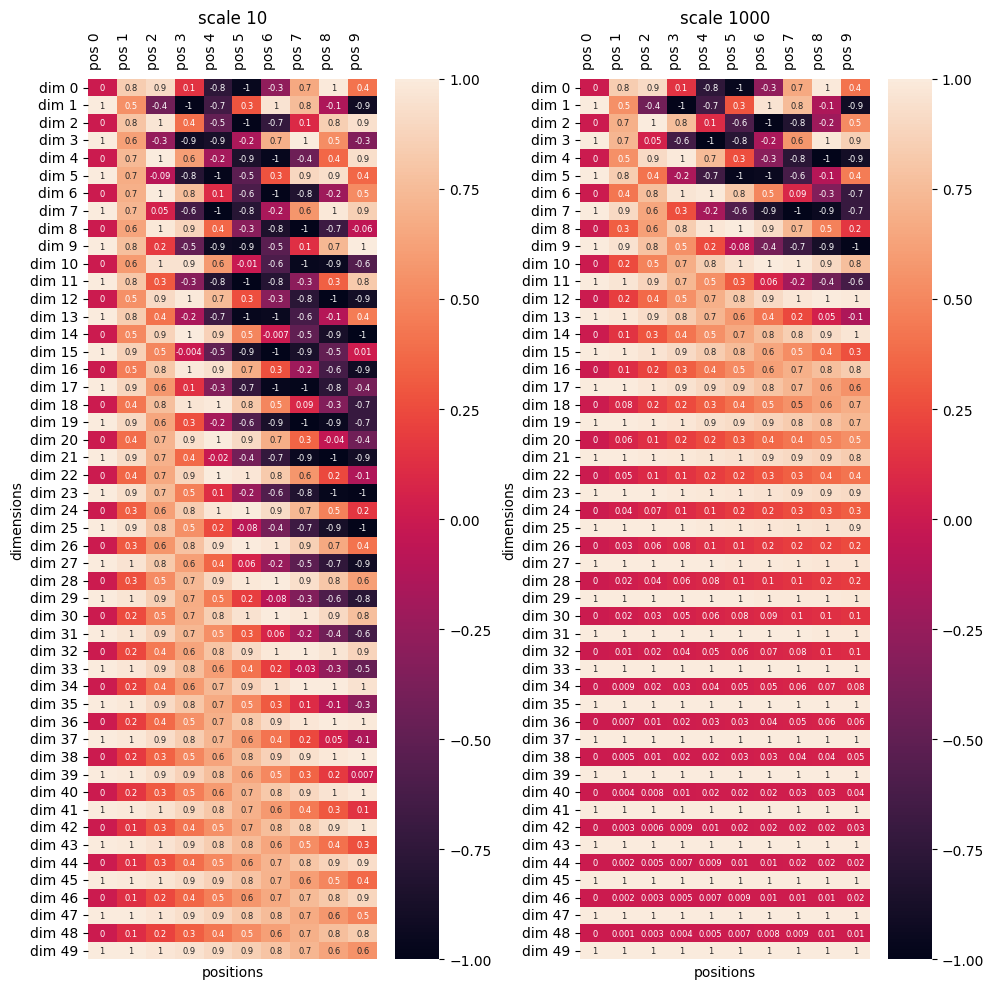

In [141]:
d_model = 50
n_tokens = 10


fig, ax = plt.subplots(1, 2, figsize=(10, 10))
pos_enc = positional_encoding_opt(d_model=d_model, n_tokens=n_tokens, scale=10)
sns.heatmap(
    pd.DataFrame(
        pos_enc,
        columns=[f"dim {i}" for i in range(d_model)],
        index=[f"pos {i}" for i in range(n_tokens)],
    ).T,
    vmin=-1,
    vmax=1,
    ax=ax[0],
    annot=True,
    fmt=".1g",
    annot_kws={"fontsize": 6}
)
ax[0].set_title("scale 10")
ax[0].set_ylabel("dimensions")
ax[0].set_xlabel("positions")
ax[0].tick_params(labelbottom = False, bottom=False, top = False, labeltop=True)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right')

pos_enc = positional_encoding_opt(d_model=d_model, n_tokens=n_tokens, scale=1000)
sns.heatmap(
    pd.DataFrame(
        pos_enc,
        columns=[f"dim {i}" for i in range(d_model)],
        index=[f"pos {i}" for i in range(n_tokens)],
    ).T,
    vmin=-1,
    vmax=1,
    ax=ax[1],
    annot=True,
    fmt=".1g",
    annot_kws={"fontsize":6}
)
ax[1].set_title("scale 1000")
ax[1].set_ylabel("dimensions")
ax[1].set_xlabel("positions")
ax[1].tick_params(labelbottom = False, bottom=False, top = False, labeltop=True)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='right')

plt.tight_layout()
plt.show()

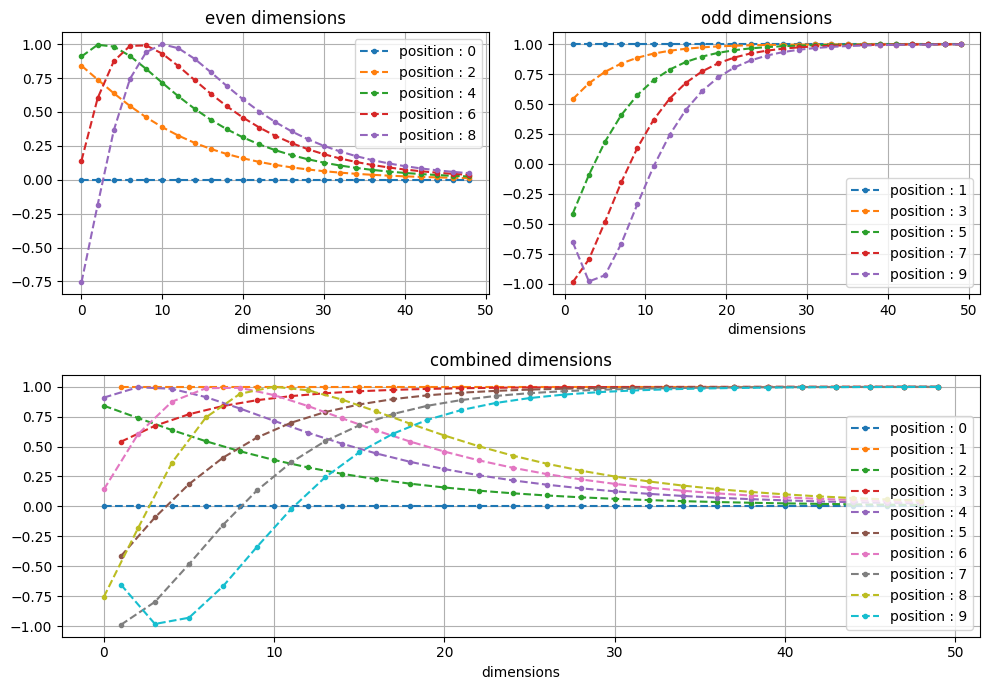

In [142]:
d_model = 50
n_tokens = 10
pos_enc = positional_encoding_opt(d_model=d_model, n_tokens=n_tokens, scale=100)

fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, (3, 4))

# individual
for i in range(int(n_tokens/2)):
    # For even position
    ax1.plot(np.arange(0, d_model, 2), pos_enc[i, 0::2], ".--", label=f"position : {2 * i}")

    # For odd position
    ax2.plot(
        np.arange(1, d_model, 2), pos_enc[i, 1::2], ".--", label=f"position : {2*i + 1}"
    )
ax1.legend()
ax1.grid()
ax1.set_title("even dimensions")
ax1.set_xlabel("dimensions")

ax2.legend()
ax2.grid()
ax2.set_title("odd dimensions")
ax2.set_xlabel("dimensions")


# combined
for i in range(int(n_tokens/2)):
    # For even position
    ax3.plot(np.arange(0, d_model, 2), pos_enc[i, 0::2], ".--", label=f"position : {2 * i}")
    
    # For odd position
    ax3.plot(
        np.arange(1, d_model, 2), pos_enc[i, 1::2], ".--", label=f"position : {2*i + 1}"
    )

ax3.legend(loc="best")
ax3.grid()
ax3.set_title("combined dimensions")
ax3.set_xlabel("dimensions")

plt.tight_layout()
plt.show()

Similarity between position 0 vs 1 and 0 vs 5

In [143]:
(
    torch.cosine_similarity(pos_enc[0].view(1, -1), pos_enc[1].view(1, -1)), 
    torch.cosine_similarity(pos_enc[0].view(1, -1), pos_enc[5].view(1, -1)),
)

(tensor([0.9382]), tensor([0.4727]))

In [144]:
(
    torch.cosine_similarity(pos_enc[1].view(1, -1), pos_enc[2].view(1, -1)), 
    torch.cosine_similarity(pos_enc[5].view(1, -1), pos_enc[2].view(1, -1)),
)

(tensor([0.9382]), tensor([0.6221]))

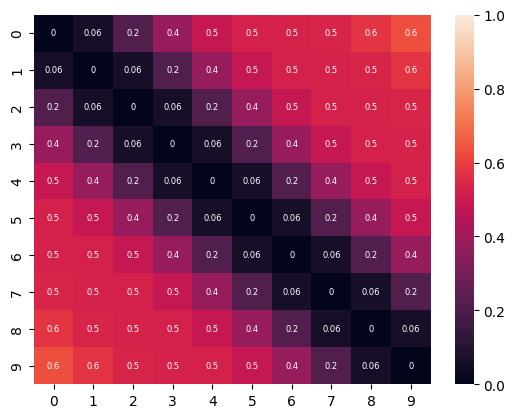

In [145]:
from sklearn.metrics.pairwise import cosine_distances

sns.heatmap(
    pd.DataFrame(
        cosine_distances(pos_enc),
    ),
    vmin=0,
    vmax=1,
    annot=True,
    fmt=".1g",
    annot_kws={"fontsize":6}
);

* Closer positions have less cosine distance makes it position aware, even it is in parallel

### Embedding + Positional Encoding

In [146]:
sentence = "I am new to NLP with deep learning."
tokens = get_tokens(sentence)

In [147]:
n_tokens = len(tokens)
d_model = 10

pos_enc = positional_encoding_opt(n_tokens=n_tokens, d_model=d_model, scale=100)
df = pd.DataFrame(
    pos_enc,
    columns=[f"dim {i}" for i in range(pos_enc.shape[1])],
    index=[f"pos {i}" for i in range(pos_enc.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,9,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
pos 1,am,12,0.841471,0.540302,0.387674,0.921796,0.157827,0.987467,0.063054,0.998010,0.025116,0.999685
pos 2,new,3,0.909297,-0.416147,0.714713,0.699417,0.311697,0.950181,0.125857,0.992048,0.050217,0.998738
pos 3,to,4,0.141120,-0.989992,0.929966,0.367644,0.457755,0.889079,0.188159,0.982139,0.075285,0.997162
pos 4,nlp,11,-0.756802,-0.653644,0.999766,-0.021631,0.592338,0.805690,0.249712,0.968320,0.100306,0.994957
pos 5,with,0,-0.958924,0.283662,0.913195,-0.407523,0.712073,0.702105,0.310272,0.950648,0.125264,0.992123
pos 6,deep,8,-0.279415,0.960170,0.683794,-0.729675,0.813960,0.580922,0.369596,0.929192,0.150143,0.988664
pos 7,learning,5,0.656987,0.753902,0.347443,-0.937701,0.895443,0.445176,0.427450,0.904039,0.174927,0.984581


In [148]:
embeddings = get_embedding(tokens, dim=d_model)

In [149]:
df = pd.DataFrame(
    embeddings,
    columns=[f"dim {i}" for i in range(embeddings.shape[1])],
    index=[f"pos {i}" for i in range(embeddings.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,9,1.724086,-2.364765,-0.929491,0.293625,1.660414,0.271740,1.465708,-0.556474,-0.744841,-0.202157
pos 1,am,12,-2.306489,0.603657,0.315085,1.142252,0.305506,-0.578882,0.564354,-0.877328,-0.269253,1.311956
pos 2,new,3,-0.389119,-0.079600,0.526932,1.619253,-0.963976,0.141520,-0.163661,-0.358223,-0.059444,-2.491939
pos 3,to,4,0.238874,1.344001,0.103226,1.100354,-0.341680,0.947339,0.622330,-0.448137,1.783661,-0.195425
pos 4,nlp,11,-0.587336,-2.061921,0.167477,0.751421,-0.197000,-0.033396,0.719292,1.064415,-0.833572,-1.192856
pos 5,with,0,1.511267,0.641871,0.472964,-0.428590,0.551371,-1.547371,0.757480,-0.406761,0.269241,1.324768
pos 6,deep,8,-0.271027,-1.439163,1.247040,1.273851,0.390949,0.387210,2.641498,-0.962401,0.948827,-1.383936
pos 7,learning,5,0.514916,-1.847478,-2.916743,-0.567330,-1.199177,-0.047417,-0.882507,0.531811,-1.545777,-0.173300


Positional Embedding

In [150]:
pos_emb = pos_enc + embeddings
pos_emb

df = pd.DataFrame(
    pos_emb,
    columns=[f"dim {i}" for i in range(pos_emb.shape[1])],
    index=[f"pos {i}" for i in range(pos_emb.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,9,1.724086,-1.364765,-0.929491,1.293625,1.660414,1.271740,1.465708,0.443526,-0.744841,0.797843
pos 1,am,12,-1.465018,1.143959,0.702760,2.064048,0.463332,0.408585,0.627408,0.120682,-0.244136,2.311641
pos 2,new,3,0.520178,-0.495747,1.241646,2.318671,-0.652279,1.091702,-0.037804,0.633826,-0.009227,-1.493201
pos 3,to,4,0.379994,0.354009,1.033192,1.467999,0.116074,1.836417,0.810489,0.534002,1.858946,0.801737
pos 4,nlp,11,-1.344139,-2.715564,1.167243,0.729790,0.395338,0.772294,0.969004,2.032735,-0.733265,-0.197900
pos 5,with,0,0.552342,0.925533,1.386159,-0.836113,1.263444,-0.845266,1.067752,0.543887,0.394505,2.316891
pos 6,deep,8,-0.550442,-0.478992,1.930834,0.544176,1.204909,0.968132,3.011095,-0.033208,1.098971,-0.395272
pos 7,learning,5,1.171903,-1.093575,-2.569300,-1.505031,-0.303734,0.397759,-0.455057,1.435850,-1.370850,0.811282


## Scaled Dot-Product Attention (SingleHead)



![scaled-dot-product-attention](./images/Arch_ScaledDotProductAttention.png) 
![multi-head-attention](./images/Arch_MultiHeadAttention.png)


* It is a communication mechanism (Message Passing for refernce in Graph Theory), where each word passes information/ communicates with other word with some weight.(weighted average/aggregation is passed through the next node from all surrounding nodes and iteratively all the information is aggregates to all the nodes)

\begin{align*}
\text{Attention}(Q, K, V) &= \text{softmax}\big( \frac{Q K^T}{\sqrt{d_k}} \big)V \\ \\
Q &= W_Q.X  & q_i &= W_Q x_i \text{ where } i \in [1, T] \\
K &= W_K.X  & k_i &= W_K x_i \text{ where } i \in [1, T] \\ 
V &= W_V.X  & v_i &= W_V x_i \text{ where } i \in [1, T] \\ \\
\end{align*}

\begin{align*}
\text{where } & \\ 
T &= \text{Number of tokens in the sentence} \\
W_Q, W_K, W_V &= \text{Projection or Learning parameters/weights for query, keys and value vectors} \\
X, x_i &= \text{Input Embedding for token in a sentence } \\ \\
\text{Where Projection Parameters Represent -} & \\
Q &= \text{What am I looking for ?} \\
K &= \text{What do I have ? } \\
V &= \text{What will I get ? } \\
\end{align*}

* Lets take an example of 2 sentences 
    * I want this to be a fair game
    * I want to go to a fair

* In these sentences word `fair` has two meanings that changes with rest of the context.
* Below is the visual representation of $QK^T$ where the multiplication should result in comparably higher value while joining(multiplying) the query and keys vectors (each token gets mulitplied by the whole query) - Information of each token is aggregated to another token, and to calculate the weights it is passed through a softmax layer.
* For example - 
    
    
    ||Query $\rightarrow$| I | want | this | to | be | a | fair | game |
    |-|-|-|-|-|-|-|-|-|-|
    |Keys $\downarrow$ | I |.|.|.|.|.|.|.|.|
    || want |.|.|.|.|.|.|.|.|
    || this |.|.|.|.|.|.|.|.| 
    || to |.|.|.|.|.|.|O|.|
    || be |.|.|.|.|.|.|O|.|
    || a |.|.|.|.|.|.|O|.|
    || fair |.|.|.|O|O|O|O|O|
    || game |.|.|.|.|.|.|O|.| 

    here it roughly represents the weights of `to`, `be`, `a`, `game` for word `fair` is higher than all the other words. This is just a representation of important information in the sentence, that passes through a position encoder to get a sense of sequence as well. Now with position and importance(affinity) it gets a lot of information.

In [151]:
d_model = 100

sentence = "I like learning NLP"

tokens = get_tokens(sentence)
X = get_embedding(tokens, dim=d_model)

### Linear Transformation

* $d_{key} = d_{query}$ as the final result has to be a square matrix. each token with information aggregated from each token
* $d_{value} = d_{model}$ as the result fo the attention will have the similar dimension as the input

In [152]:
d_query, d_key  = (24, 24)
d_value = d_model

W_Q = torch.rand(d_query, d_model, requires_grad=True) * 1e-1
W_K = torch.rand(d_key, d_model, requires_grad=True) * 1e-1
W_V = torch.rand(d_value, d_model, requires_grad=True) * 1e-1


In [153]:
Q = torch.matmul(X, W_Q.T)

# alternatively 
# W_Q = torch.nn.Linear(d_model, bias=False)
# Q = W_Q(X)
K = torch.matmul(X, W_K.T)
V = torch.matmul(X, W_V.T)

Q.shape, K.shape, V.shape

(torch.Size([4, 24]), torch.Size([4, 24]), torch.Size([4, 100]))

### Q . K

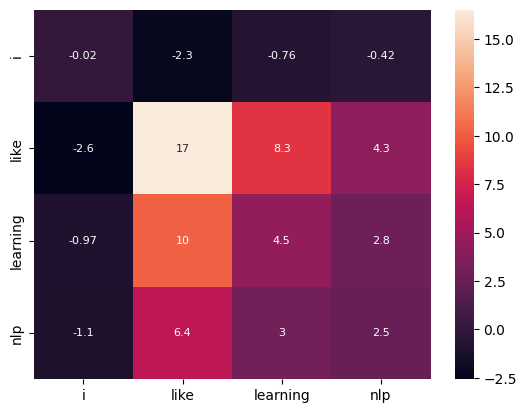

In [154]:
omega = Q @ K.T

sns.heatmap(pd.DataFrame(
    torch.round(omega, decimals=2).detach().numpy(),
    columns=sentence_separator(sentence),
    index=sentence_separator(sentence),
), annot=True, annot_kws={"size" : 8}) ;

### Softmax

In [155]:
def softmax(x):
    if len(x.shape) == 1:
        x = x.view(1, -1)
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1).view(-1, 1)


softmax(torch.Tensor([1, 1, 1, 1])), softmax(torch.Tensor([[1, 1, 1, -1], [1, 2, 1, 4]]))

(tensor([[0.2500, 0.2500, 0.2500, 0.2500]]),
 tensor([[0.3189, 0.3189, 0.3189, 0.0432],
         [0.0403, 0.1096, 0.0403, 0.8098]]))

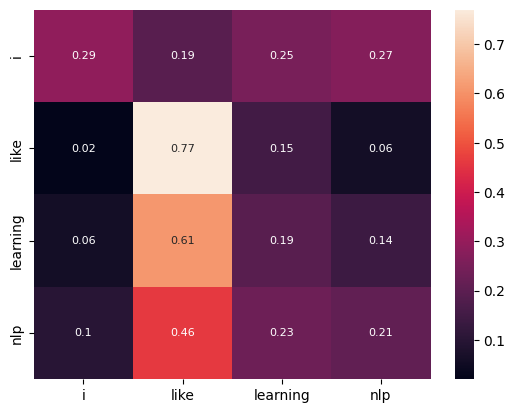

In [156]:
omega = softmax((Q @ K.T) / math.sqrt(d_key))

sns.heatmap(pd.DataFrame(
    torch.round(omega, decimals=2).detach().numpy(),
    columns=sentence_separator(sentence),
    index=sentence_separator(sentence),
), annot=True, annot_kws={"size" : 8}) ;

### Why Scaling?

* dividing by $\sqrt{d_k}$

In [157]:
Q @ K.T

tensor([[-0.0239, -2.2627, -0.7641, -0.4180],
        [-2.5819, 16.5150,  8.3348,  4.3155],
        [-0.9701, 10.1539,  4.4951,  2.8491],
        [-1.1309,  6.4240,  3.0206,  2.5019]], grad_fn=<MmBackward0>)

Here the value of last cell has become very big and if this matrix is passed through softmax then it will become a one-hot vector, instead of fairly diffused vector

In [158]:
softmax(Q @ K.T)

tensor([[4.4290e-01, 4.7205e-02, 2.1125e-01, 2.9864e-01],
        [5.0838e-09, 9.9971e-01, 2.8005e-04, 5.0316e-06],
        [1.4692e-05, 9.9584e-01, 3.4721e-03, 6.6945e-04],
        [4.9694e-04, 9.4914e-01, 3.1569e-02, 1.8793e-02]],
       grad_fn=<DivBackward0>)

Now if we scale it with the value

In [159]:
(Q @ K.T)  / math.sqrt(d_key)

tensor([[-0.0049, -0.4619, -0.1560, -0.0853],
        [-0.5270,  3.3711,  1.7013,  0.8809],
        [-0.1980,  2.0727,  0.9176,  0.5816],
        [-0.2308,  1.3113,  0.6166,  0.5107]], grad_fn=<DivBackward0>)

In [160]:
softmax((Q @ K.T)  / math.sqrt(d_key))

tensor([[0.2928, 0.1854, 0.2517, 0.2701],
        [0.0157, 0.7743, 0.1458, 0.0642],
        [0.0628, 0.6085, 0.1917, 0.1370],
        [0.0989, 0.4625, 0.2309, 0.2077]], grad_fn=<DivBackward0>)

* Now whole purpose of softmax is provide weights to each token and aggregate the results in value, but if there are sharp/high values in dot product resulting in one-hot encoded softmax weights then we are just taking value from one token while ignoring the other. and these extreme cases will be very frequent.

### Attention

Multiplying weights with the values

In [161]:
def attention(Q, K, V, d_key):
    omega = softmax((Q @ K.T) / np.sqrt(d_key))
    return omega @ V

In [162]:
attn_out = attention(Q, K, V, d_key)

attn_out.shape

torch.Size([4, 100])

In [163]:
df = pd.DataFrame(
    attn_out.detach().numpy(),
    columns=[f"dim {i}" for i in range(attn_out.shape[1])],
    index=sentence_separator(sentence),
)
df

,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9,...,dim 90,dim 91,dim 92,dim 93,dim 94,dim 95,dim 96,dim 97,dim 98,dim 99
i,-0.573570,-0.189312,-0.362841,-0.108811,-0.166248,-0.316315,-0.072527,-0.127458,-0.208524,-0.373912,...,-0.307311,-0.484463,-0.139491,-0.076385,-0.311829,-0.302110,-0.368912,-0.355659,-0.380370,-0.377440
like,-0.978687,-0.448983,-1.050566,-0.608582,-0.539180,-0.558762,-0.852304,-0.621336,-0.610566,-0.489147,...,-0.464679,-0.614733,-0.755129,-0.356164,-0.641136,-0.965040,-1.046479,-0.703709,-0.717843,-0.705466
learning,-0.873964,-0.393216,-0.876271,-0.480671,-0.434900,-0.492697,-0.649174,-0.498606,-0.509684,-0.458236,...,-0.426079,-0.591250,-0.607068,-0.287512,-0.554527,-0.792680,-0.873869,-0.628118,-0.631725,-0.631576
nlp,-0.782927,-0.349239,-0.724827,-0.370100,-0.343555,-0.435498,-0.472087,-0.389682,-0.420164,-0.429234,...,-0.392273,-0.572704,-0.480539,-0.229305,-0.479363,-0.643323,-0.723984,-0.564499,-0.557958,-0.567673


### Embedding + Positional Encoding + Attention

In [164]:
d_model = 10

sentence = "I like NLP with deep learning."

tokens = get_tokens(sentence)
n_tokens = len(tokens)

embeddings = get_embedding(tokens, dim=d_model)
embeddings.shape

torch.Size([6, 10])

In [165]:
pos_enc = positional_encoding_opt(n_tokens=n_tokens, d_model=d_model, scale=100)

d_query, d_key, d_value = 10, 10, d_model

W_Q = torch.rand(d_query, d_model, requires_grad=True) * 1e-1
W_K = torch.rand(d_key, d_model, requires_grad=True) * 1e-1
W_V = torch.rand(d_value, d_model, requires_grad=True) * 1e-1

In [166]:
pos_emb = pos_enc + embeddings

In [167]:
Q = torch.matmul(pos_emb, W_Q.T)
K = torch.matmul(pos_emb, W_K.T)
V = torch.matmul(pos_emb, W_V.T)


attn_out = attention(Q, K, V, d_key)

df = pd.DataFrame(
    attn_out.detach().numpy(),
    columns=[f"dim {i}" for i in range(attn_out.shape[1])],
    index=[f"pos {i}" for i in range(attn_out.shape[0])],
)

df.insert(
    loc=0,
    column="word",
    value=sentence_separator(sentence),
)
df

,word,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,0.080582,-0.022017,0.055352,0.211515,0.180032,0.081592,0.149459,0.013435,0.093827,0.101240
pos 1,like,0.089365,-0.014022,0.060149,0.215729,0.182867,0.083341,0.150635,0.016239,0.098191,0.109004
pos 2,nlp,0.080786,-0.021523,0.054936,0.211341,0.180314,0.081881,0.149208,0.013803,0.093821,0.101418
pos 3,with,0.082540,-0.019528,0.056182,0.211877,0.180728,0.082628,0.149137,0.014492,0.094457,0.103548
pos 4,deep,0.077296,-0.024841,0.052477,0.209521,0.179240,0.081356,0.148570,0.012589,0.091893,0.098034
pos 5,learning,0.081714,-0.021371,0.055261,0.212030,0.180465,0.081804,0.149710,0.013767,0.094475,0.101666


## MultiHead Attention

Now the one attention can run in multiple heads parallelly to generative different transformations.


\begin{align*}
\text{Multihead}(Q, K, V) &= \text{Concat}(head_1, head_2, ... , head_h) W^o \\\\
\text{where } head_i &= \text{Attention}(QW_i^Q,KW_i^K,VW_i^V)
\end{align*}

![scaled-dot-product-attention](./images/Arch_ScaledDotProductAttention.png) 
![multi-head-attention](./images/Arch_MultiHeadAttention.png)

In [168]:
d_model = 100
n_heads = 3

sentence = "I like NLP with deep learning."

tokens = get_tokens(sentence)
X = get_embedding(tokens, dim=d_model).repeat(n_heads, 1, 1)

In [169]:
d_query, d_key, d_value = 28, 28, d_model

W_Q = torch.rand(n_heads, d_query, d_model, requires_grad=True) * 1e-1
W_K = torch.rand(n_heads, d_key, d_model, requires_grad=True) * 1e-1
W_V = torch.rand(n_heads, d_value, d_model, requires_grad=True) * 1e-1

In [170]:
X.shape, W_Q.shape

(torch.Size([3, 6, 100]), torch.Size([3, 28, 100]))

In [171]:
Q = torch.bmm(X, W_Q.transpose(-2, -1)) # Transposing last two dimensions (leaving heads)
K = torch.bmm(X, W_K.transpose(-2, -1))
V = torch.bmm(X, W_V.transpose(-2, -1))

Q.shape, K.shape, V.shape

(torch.Size([3, 6, 28]), torch.Size([3, 6, 28]), torch.Size([3, 6, 100]))

In [172]:
def multihead_softmax(x):
    return torch.exp(x)/ torch.exp(x).sum(dim=-1, keepdim=True)

def multihead_attention(Q, K, V, d_key):
    omega = (Q @ K.transpose(-2, -1)) / math.sqrt(d_key)
    return multihead_softmax(omega) @ V

In [173]:
attn_out = multihead_attention(Q, K, V, d_key)

attn_out.shape

torch.Size([3, 6, 100])

## Masked-MultiHead Attention (Optional)

![scaled-dot-product-attention](./images/Arch_ScaledDotProductAttention.png) 
![multi-head-attention](./images/Arch_MultiHeadAttention.png)


* mask the tokens that come in next steps (as -inf)
* so that softmax converts them to zero
* In cases of chatbot, the algorithm should not know the next word at the time of training
* so that it can predict the probability of next word based on target values and hadn't seen the value before


> This is an optional step where word prediction/generation is the use case, Hence it can be ignored for the use cases like **Language Translation**, **Sentiment Analysis** etc., where we need the whole sentence and each token to talk to each other

* Create a mask where the next word in sequence cannot communicate the previous token, mathematic before passing it to softmax next token variable in sequence are converted to -inf ($-\infty$) because $e^{-\infty} = 0$

In [174]:
math.exp(-math.inf)

0.0

In [175]:
# for example there are 5 tokens in the input sentence
M = torch.rand((5, 5))
M

tensor([[0.9828, 0.8134, 0.5962, 0.1913, 0.9699],
        [0.2390, 0.8606, 0.4693, 0.5675, 0.6274],
        [0.6192, 0.6563, 0.4269, 0.2508, 0.6540],
        [0.8481, 0.3248, 0.8599, 0.0505, 0.0085],
        [0.7607, 0.0670, 0.3214, 0.7319, 0.4123]])

In [176]:
M[torch.tril(M) == 0 ] = float("-inf")
M
# M.masked_fill(torch.tril(M) == 0, float("-inf"))

tensor([[0.9828,   -inf,   -inf,   -inf,   -inf],
        [0.2390, 0.8606,   -inf,   -inf,   -inf],
        [0.6192, 0.6563, 0.4269,   -inf,   -inf],
        [0.8481, 0.3248, 0.8599, 0.0505,   -inf],
        [0.7607, 0.0670, 0.3214, 0.7319, 0.4123]])

<Axes: >

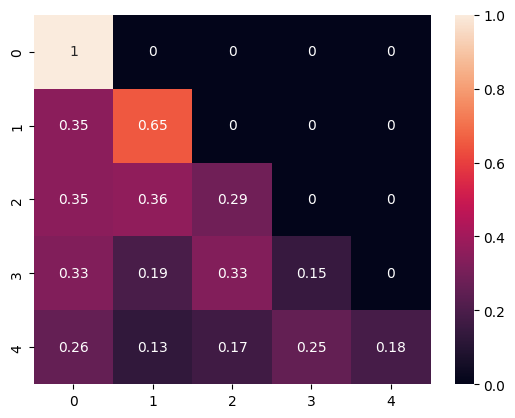

In [177]:
masked_softmax = softmax(M)
sns.heatmap(masked_softmax, annot=True)

In [178]:
def multihead_attention(Q, K, V, d_key, masked=False):
    omega = Q @ K.transpose(-2, -1)/ math.sqrt(d_key)
    if masked:
        omega = omega.masked_fill(torch.tril(omega) == 0, float("-inf"))
    return multihead_softmax(omega) @ V

### Masked Softmax

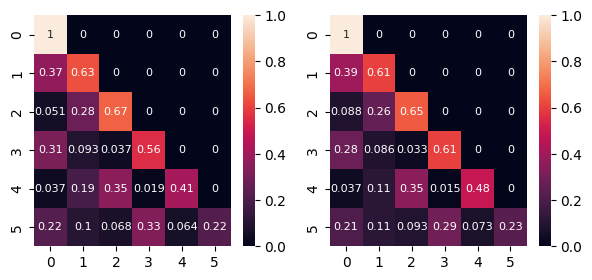

In [179]:
omega = Q @ K.transpose(-2, -1)  / math.sqrt(d_key)
omega = omega.masked_fill(torch.tril(omega) == 0, float("-inf"))
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
sns.heatmap(multihead_softmax(omega)[0].detach().numpy(), annot=True, ax=ax[0], annot_kws={"size": 8})
sns.heatmap(multihead_softmax(omega)[1].detach().numpy(), annot=True, ax=ax[1], annot_kws={"size": 8})
fig.show()

* Now only previous words/affinity will give context to the current tokens

In [180]:
masked_attn_out = multihead_attention(Q, K, V, d_key, masked=True)

masked_attn_out.shape

torch.Size([3, 6, 100])

## Self Attention Vs Cross Attention

* Attention supports both masked and non-masked multihead attention as it provides the fecility to Self-Attention & Cross-Attention.
* When Query, Key and Value all are from **Same Source** then It is called Self-Attention.
* Where Query is from **One Source** and Key, Value are from **Another Source** then it is called Cross-Attention.

## Add & Norm (Convergence Optimizations)

![Add & Norm](images/Arch_Add&Norm.png)

### Skip Connections (Add)

* In skip connections a copy of input is added with the output of the set of calculations.
* In this particular example input embeddings are added with the results of Multi-Head Attention.


```sh

                  Input (X)
                   |
                   |
                   o Fork
                   | \
          |        |   \               A
          |        |     \             |
          |        |       |           |
          |        |   |-----------|   |
          |        |   |  Multi    |   |   Backward
Forward   |        |   |    |      |   |  
          |        |   |  Head     |   |
          |        |   |    |      |   |
          V        |   | Attention |
                   |   |-----------|
                   |       |
                   |      /
                   |    /
                   |  /
                  addition
                   |
                   |
                  Output (X)

```

* Because of skip connection the gradients can travel faster to initial layers and initial layers can learn as fast as final layers, This helps when we are building very Deep Neural Networks

In [181]:
X.shape, masked_attn_out.shape

(torch.Size([3, 6, 100]), torch.Size([3, 6, 100]))

In [182]:
add_x = X + masked_attn_out
add_x.shape

torch.Size([3, 6, 100])

### Layer Normalization


\begin{align*}
y_i &= \frac{x_i - \mu}{\sqrt{ \sigma^2 - \epsilon}}. \gamma + \beta \\\\
\text{where } \\
\mu &= \text{mean} \\ 
\sigma^2 &= \text{variance} \\
\epsilon &= \text{constant for numerical stability} \\
\gamma &= \text{learnable parameter for rescale, initialized with 1} = \frac{\delta L}{\delta \gamma} \\
\beta &= \text{learnable parameter for reshift, initialized with 0} = \frac{\delta L}{\delta \beta}
\end{align*}

* This is row-wise normalization, which is different from batch normalization, which makes it independent from batch size.
* Normalization makes it better for convergence, and better generalization.
* Consider all tokens/rows with different different distribution with same distribution type, It would be optimum to converege if we all the tokens dimensions are normalized.

In [183]:
layer_norm = torch.nn.LayerNorm(add_x.shape[-1])

In [184]:
norm_out = layer_norm(add_x)
norm_out.shape

torch.Size([3, 6, 100])

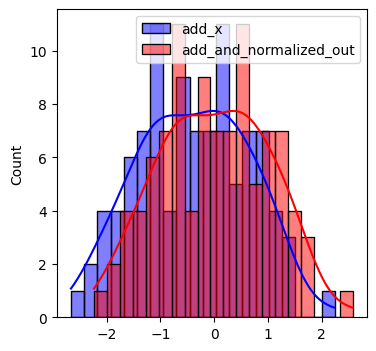

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# fade bars
sns.histplot(add_x[0, 0, :].detach().numpy(), bins=20, ax=ax, kde=True, color='blue', label='add_x' )
sns.histplot(norm_out[0, 0, :].detach().numpy(), bins=20, ax=ax, kde=True, color='red', label='add_and_normalized_out')
ax.legend()
fig.show();

This shows before and after the normalization distribution is slightly moved towards 0.